# Turbine check-out/calibration notebook

Use this notebook to set up a series of runs for turbine calibration and check-out

In [1]:
%%capture 

# Important header information
amrwindfedir = '/Users/pmohan/repos/amr-wind-frontend'
import sys, os
sys.path.insert(1, amrwindfedir)

# Load the libraries
import matplotlib.pyplot as plt
import amrwind_frontend as amrwind
import tempfile
import shutil
# Also ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Make all plots inline 
%matplotlib inline

In [2]:
# Start the amrwind_frontend app 
case = amrwind.MyApp.init_nogui()

In [3]:
curdir = os.getcwd()

tempdir = 'jdm_calib_dir'
os.makedirs(tempdir, exist_ok=True)
os.chdir(tempdir)
print(f'Using temporary directory: {tempdir}')

Using temporary directory: jdm_calib_dir


## Set up the basic simulation properties

In [4]:
rhodensity = 1.225
WS         = 6.0                                     # This is temporary, we will vary across a range below
eps        = 5.0
case.setAMRWindInput('useWSDir', True)
case.setAMRWindInput('ABL_windspeed', WS, forcechange=True)
case.setAMRWindInput('ABL_winddir', 270,  forcechange=True)
case.ABL_calculateWindVector()

In [5]:
case.setAMRWindInput('time_control',   ['const dt'])
case.setAMRWindInput('time.stop_time', 360)
case.setAMRWindInput('time.fixed_dt',  0.1)
case.setAMRWindInput('incflo.physics', ['FreeStream', 'Actuator'])

In [6]:
case.setAMRWindInput('ConstValue.density.value',  rhodensity)
case.setAMRWindInput('incflo.density',            rhodensity)
case.setAMRWindInput('incflo.velocity',           [WS, 0.0, 0.0])
case.setAMRWindInput('ConstValue.velocity.value', [WS, 0.0, 0.0])
case.setAMRWindInput('turbulence.model',          ['Laminar'])

## Set the BC's

In [7]:
case.setAMRWindInput('is_periodicx', False)
case.setAMRWindInput('is_periodicy', True)
case.setAMRWindInput('is_periodicz', True)  

case.setAMRWindInput('xlo.type', 'mass_inflow')
case.setAMRWindInput('xhi.type', 'pressure_outflow')
case.setAMRWindInput('xlo.density',  rhodensity)
case.setAMRWindInput('xlo.velocity', [WS, 0.0, 0.0])

In [8]:
# Add the turbine specifications flag
## Note that the options field can have things like:
##    ADparam_TwrAero:False ADparam_TwrShadow:0 FSTparam_TMax:181234.0
## To specify changes to the OpenFAST model
turbinescsv="""
# CSV file should have columns with
# name, x, y, type, yaw, hubheight, options
T0,     0, 0, JDM_5MW, 270.0, 0.0, 
"""
case.setAMRWindInput('turbines_csvtextbox',  turbinescsv)

In [9]:
case.setAMRWindInput('turbines_domainsize', [2560.0*2, 960.0*2, 960.0*2])
case.setAMRWindInput('turbines_backgroundmeshsize', 20.0)
case.setAMRWindInput('turbines_deleteprev', True)
case.setAMRWindInput('turbines_freespace', True)   # Make this have no ground

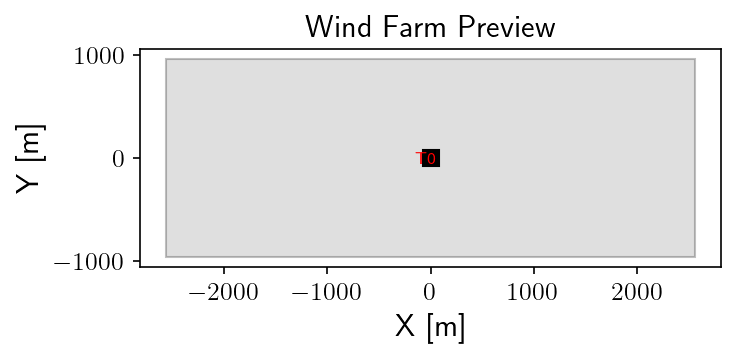

In [10]:
# Preview the turbine layout
fig, ax = plt.subplots(figsize=(5,5), facecolor='w', dpi=150)
case.turbines_previewAllTurbines(ax=ax)

In [11]:
# Now create the turbines
case.turbines_createAllTurbines()

# Print out existing list of turbines, just to confirm that the turbines got made
print(case.listboxpopupwindict['listboxactuator'].getitemlist())

CANNOT update: ABLMeanBoussinesq use forcechange=True in setval()
['T0']


In [12]:
# Set some globals
case.setAMRWindInput('Actuator_default_type', ['JoukowskyDisk'])
case.setAMRWindInput('Actuator_JoukowskyDisk_density',       rhodensity,      forcechange=True)
case.setAMRWindInput('Actuator_JoukowskyDisk_epsilon',       [eps], forcechange=True)
case.setAMRWindInput('Actuator_JoukowskyDisk_diameters_to_sample',       2.0, forcechange=True)

## Add turbine refinement

In [13]:
refinementcsv="""
# CSV file should have columns with
# level, upstream, downstream, lateral, below, above, options
level, upstream, downstream, lateral, below, above, options
0,     10,       10,         3,       2,     2,     center:farm
1,     2.5,      2.5,        2.5,     1.2,   1.2,   center:farm
2,     1,        1,          0.75,    0.8,   0.8,  
"""
case.setAMRWindInput('refine_csvtextbox', refinementcsv)
case.setAMRWindInput('refine_deleteprev', True)

In [14]:
case.refine_createAllZones()
# Print out existing list of turbines
print(case.listboxpopupwindict['listboxtagging'].getitemlist())

['Farm_level_0_zone', 'Farm_level_1_zone', 'T0_level_2_zone']


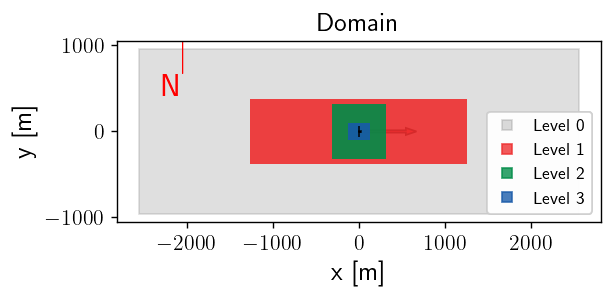

In [15]:
# Plot the domain
fig, ax2 = plt.subplots(figsize=(5,5), facecolor='w', dpi=125)
case.popup_storteddata['plotdomain']['plot_turbines']        = case.listboxpopupwindict['listboxactuator'].getitemlist()
case.popup_storteddata['plotdomain']['plot_refineboxes']     = case.listboxpopupwindict['listboxtagging'].getitemlist()
case.plotDomain(ax=ax2)

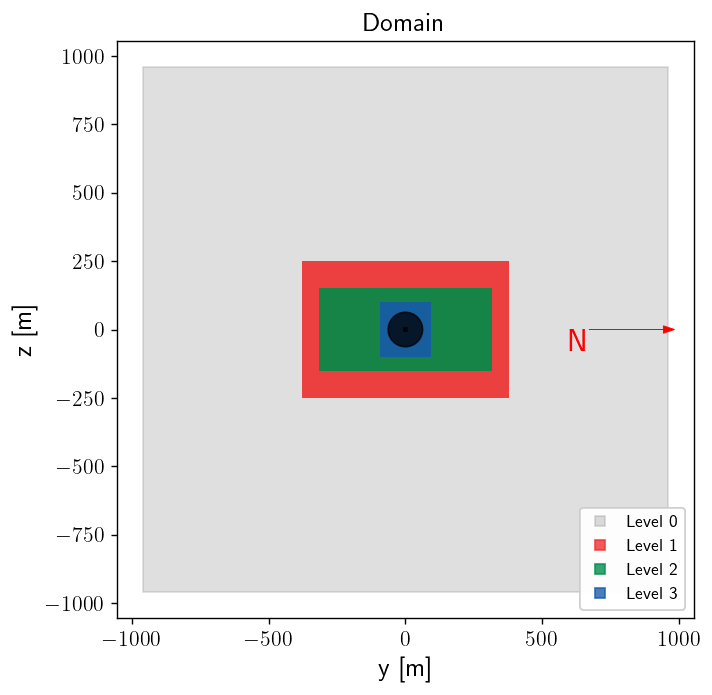

In [16]:
# Plot the domain
fig, ax = plt.subplots(figsize=(8,6), facecolor='w', dpi=125)
case.popup_storteddata['plotdomain']['plot_chooseview']      = 'YZ'
case.popup_storteddata['plotdomain']['plot_refineboxes']     = case.listboxpopupwindict['listboxtagging'].getitemlist()
case.popup_storteddata['plotdomain']['plot_sampleprobes']    = [] #case.listboxpopupwindict['listboxsampling'].getitemlist()
case.popup_storteddata['plotdomain']['plot_turbines']        = case.listboxpopupwindict['listboxactuator'].getitemlist()
case.plotDomain(ax=ax)

In [17]:
case.estimateMeshSize()

Refinement Farm_level_0_zone: level 1: 960180 cells
Refinement Farm_level_1_zone: level 2: 960180 cells
Refinement T0_level_2_zone: level 3: 614515 cells
ESTIMATED MESH SIZE
   Level       Ncells                      Cell Size
       0      2359296             20.0 x 20.0 x 20.0
       1       960180             10.0 x 10.0 x 10.0
       2       960180                5.0 x 5.0 x 5.0
       3       614515                2.5 x 2.5 x 2.5
  TOTAL:      4894171


### Create sampling planes

In [18]:
samplingcsv="""
# CSV file should have columns withturbinescsv=
# name, type, upstream, downstream, lateral, below, above, n1, n2, options
name, type, upstream, downstream, lateral, below, above, n1, n2, options
#cl1, centerline, 1,  0, none, none,  none,  11, 11, none
#rp1, rotorplane, 2,  0, none, none,  none,  11, 11, none
#sw1, streamwise, 2,  1, 1, 0.5,  0.5,  11, 11, usedx:0.25 noffsets:1
hh,  hubheight,2560,2560,960, 0,  none,  11, 11, usedx:10 units:meter center:farm orientation:x
"""
case.setAMRWindInput('sampling_csvtextbox', samplingcsv)
case.setAMRWindInput('sampling_deleteprev', True)

In [19]:
case.sampling_createAllProbes(verbose=False)
# Print out existing list of turbines
print(case.listboxpopupwindict['listboxsampling'].getitemlist())

['Farm_hh']


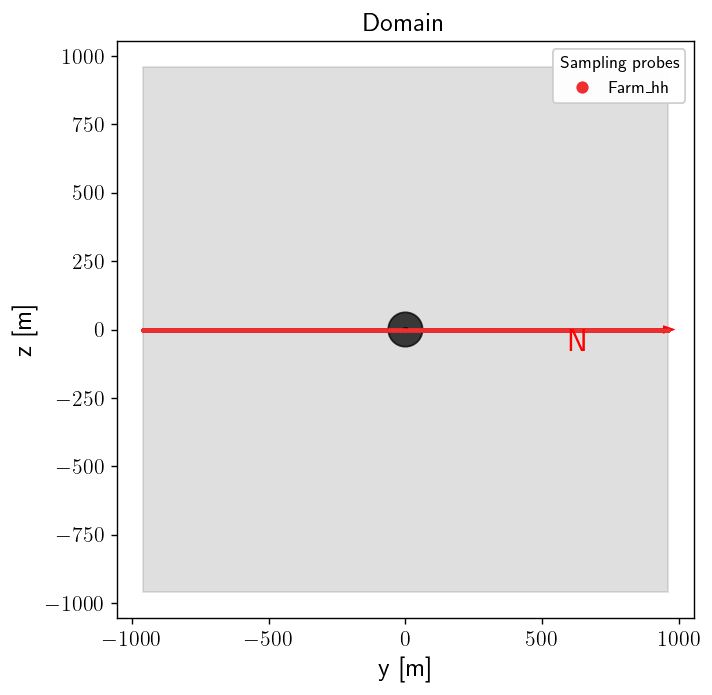

In [20]:
# Plot the domain
fig, ax = plt.subplots(figsize=(8,6), facecolor='w', dpi=125)
case.popup_storteddata['plotdomain']['plot_refineboxes']     = [] #case.listboxpopupwindict['listboxtagging'].getitemlist()
case.popup_storteddata['plotdomain']['plot_sampleprobes']    = case.listboxpopupwindict['listboxsampling'].getitemlist()
case.popup_storteddata['plotdomain']['plot_turbines']        = case.listboxpopupwindict['listboxactuator'].getitemlist()
case.plotDomain(ax=ax)

In [21]:
print(case.writeAMRWindInput(''))

# --- Simulation time control parameters ---
time.stop_time                           = 360.0               # Max (simulated) time to evolve [s]
time.max_step                            = -1                  
time.fixed_dt                            = 0.1                 # Fixed timestep size (in seconds). If negative, then time.cfl is used
incflo.physics                           = FreeStream Actuator # List of physics models to include in simulation.
incflo.verbose                           = 0                   
io.check_file                            = chk                 
incflo.use_godunov                       = true                
incflo.godunov_type                      = weno_z              
turbulence.model                         = Laminar             
incflo.gravity                           = 0.0 0.0 -9.81       # Gravitational acceleration vector (x,y,z) [m/s^2]
incflo.density                           = 1.225               # Fluid density [kg/m^3]
transport.viscosity 

## Set up a wind sweep

In [22]:
# Set the parameters
case.setAMRWindInput('sweep_windspeeds', '6 9 12')
case.setAMRWindInput('sweep_winddirs',   '270')
case.setAMRWindInput('sweep_caseprefix', 'Calibrate_dx2p5_{CASENUM}_EPS%0.2f_WS_{WS}'%eps)
case.setAMRWindInput('sweep_dirprefix',  'Calibrate_dx2p5_{CASENUM}_EPS%0.2f_WS_{WS}'%eps)
case.setAMRWindInput('sweep_usenewdirs', True)
case.setAMRWindInput('sweep_logfile',    'RunCalibration_dx2.5_Eps%0.2f_logfile.yaml'%eps)

In [23]:
case.setAMRWindInput('sweep_createsubmitscript', False)
case.setAMRWindInput('sweep_submitjob',          False)
case.sweep_SetupRunParamSweep(verbose=True)
case.writeFarmSetupYAML('TurbineCalibrate5MWJDM_dx2.5_Eps%0.2f.yaml'%eps)

       NUM           WS         WDir            Case name
       ---           --         ----            ---------
         0      6.00000    270.00000 Calibrate_dx2p5_0_EPS5.00_WS_6.0
         1      9.00000    270.00000 Calibrate_dx2p5_1_EPS5.00_WS_9.0
         2     12.00000    270.00000 Calibrate_dx2p5_2_EPS5.00_WS_12.0
Saved farm setup to TurbineCalibrate5MWJDM_dx2.5_Eps5.00.yaml


In [24]:
os.chdir(curdir) #change back to the original directory